Katherine Elder

The purpose of this notebook is to create a matrix of the maximum amplitude and corresponding delay for each antenna pair. 

To do this, we read in a file holding the entire run of data and then run through every unique antenna pair. Without plotting, we find the maximum amplitude (y-value) and it's corresponding delay (x-value). These numbers are placed into arrays and the loop moves onto the next antenna pair. 

Finally, we use plt.matshow to display the arrays side by side as matrices so that we will be able to see if any patterns appear. 

We also want to be able to plot the positions of the antennas with their amplitudes. 

In [34]:
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib
#Create uv elements
uvx = UVData()
uvy = UVData()

First, I ran a test to check my logic

[[12, 16, 14, 21, 10], [16, 15, 4, 13, 12], [17, 6, 19, 17, 8], [21, 21, 7, 5, 19], [6, 14, 12, 20, 7]]


<IPython.core.display.Javascript object>


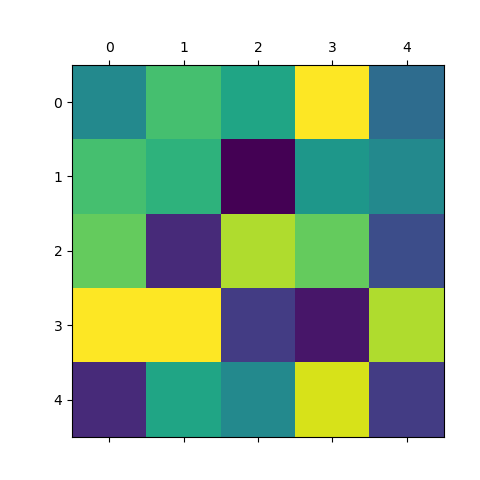

In [35]:
import random

# Create an empty test array
test = []

# Use for loops to step through and create a 5x5 array
for i in range(5):
    # Create a column array to hold the values
    col = []
    for j in range(5):
        # Append the new value to the end of the column array
        rand_num = random.randint(1,21)
        col.append(rand_num)
    # Append the column array to the end of the test array
    test.append(col)
    
# Print the test array
print test
# Plot the array as a matrix
plt.matshow(test) 

So here's what I want to do: use the test code above to help me create the array of amplitudes. I should also make a separate array to hold the delay times, since plt.matshow doesn't like arrays of lists. 

Initialize the amp array.

Step into loop for the antenna pair. Only 52 antennas online, but with dead antenna removed only 46 antennas used.

Run through the file and take the fourier transforms. 

Find max of vis_avg_delay and put into amp array. 

Find corresponding delay value and put into delay array. 

Restart loop for new antenna pair. 

Convert data arrays to find the corrdinates necessary for building the matrix.

In [36]:
# Read in the xy data file
uvx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_6.uvOCRSL.uvfits')

# Read in the yx data file
uvy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_7.uvOCRSL.uvfits')

#Create an array of antennas we want to flag
flagged_antennas = [0,2,26,50,98,136]

First, we read in and get the XY polarized data

In [37]:
def make_max_arrays(uv,keep_flags=False):
    '''
    The purpose of this function is to read in all antenna pairs
    and produce an array of the maximum amplitudes and an array
    of the corresponding delay times. 

    Parameters 
    ----------
    uv : uv data object
        Name of the uv object being used
    keep_flags : bool, optional
        If this is set to True, a zero will be inserted into the 
        amplitude array.
        If the default value is passed, then the function will continue
        and nothing will be placed into the array.
    
    Returns
    -------
    max_amp, delays : ndarrays
        The first array holds the maximum amplitudes. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
        The second array holds the corresponding delay times. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
    '''
    
    #Create the arrays to be returned
    max_amp=[]
    delays=[]
    
    
    for i,ant1 in enumerate(uv.ant_1_array):
        #Get the second antenna number using the index number
        ant2 = uv.ant_2_array[i]
        
        #Flag out dead antennas
        #If keep_flags is set to True, a zero entry will be added to the arrays
        #If keep_flags is set to False, the function continues
        if np.any(ant1==flagged_antennas) and keep_flags:
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant1==flagged_antennas):
            continue

        if np.any(ant2==flagged_antennas) and keep_flags:
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant2==flagged_antennas):
            continue
            
        # Check if the antenna numbers are equal
        #If they are, the function will continue
        #If keep_flags is also set to True, a zero entry will be added to the arrays
        #'''
        if ant1==ant2 and keep_flags:
            #print 'same antennas'
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif ant1==ant2:
            #print 'same antennas'
            continue
        #'''
        
        # Create an array to hold the night's data
        spectrum=uv.data_array[i,0,:,0]
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uv.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        max_peak = np.max(np.abs(vis_avg_delay))
        #Find the corresponding delay
        corr_delay = con_delays[np.argmax(np.abs(vis_avg_delay))]
        # Append the maximum amplitude array with a list of the antenna pair and the peak
        max_amp.append([ant1,ant2,max_peak])
        #Append the delay array with a list of the antenna pair and the time
        delays.append([ant1,ant2,corr_delay])

    #Convert to numpy arrays
    max_amp = np.array(max_amp)
    delays = np.array(delays)
    
    #Return the created arrays
    return max_amp, delays;

In [38]:
def make_matrix_array(amp_array,delay_array,antnum=None,index=False):
    '''
    The purpose of this function is to correctly fill the arrays
    that will be used to plot the matrices. 
    
    Parameters
    ----------
    amp_array : ndarray
        The array holding the amplitudes
    delay_array : ndarray
        The array holding the delay times
    antnum : int, optional
        The antenna number of a specific antenna to check for. Default is none. 
    index : bool, optional
        If this is set to True, the index number for the entered antenna number
        will be returned as well. 
        
    Returns
    -------
    amp_matrix,delay_matrix : ndarrays
        The first array holds the amplitudes correctly shaped to 
        produce the matrix. 
        The second array hold the delays correctly shaped to
        produce the matrix. 
    OR
    amp_matrix,delay_matrix,indexnum,dindexnum : ndarrays, ints
        The first array holds the amplitudes correctly shaped to 
        produce the matrix. 
        The second array hold the delays correctly shaped to
        produce the matrix. 
        indexnum is the integer index number of the amplitude matrix 
        for the entered antenna. This is only returned if index is set to True.
        dindexnum is the integer index number of the delay matrix for the 
        entered antenna. This is only returned if index is set to True.
    
    '''
    #Get a list of all of the antennas used and sort them
    antennas = list(set(amp_array[:,0]))
    antennas.sort()
    #Find the number of antennas
    nants_peak = len(antennas)
    #Create arrays to index for the matrix
    amp_matrix = np.zeros((nants_peak,nants_peak))
    delay_matrix = np.zeros((nants_peak,nants_peak))
    
    #Fill the amplitude matrix array
    for ant1,ant2,peak in amp_array:
        #Get the coordinates
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #This check forces the matrix to look nice
        if index:
            if ant1==antnum:
                #print ant1,ant2
                #print peak
                amp_matrix[i,j] = peak
                indexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                #print ant1,ant2
                #print peak
                amp_matrix[j,i] = peak
                indexnum = np.argwhere(antennas==ant2)
            else:
                amp_matrix[i,j] = 0
        elif j<i:
            amp_matrix[j,i] = peak
        else:
            amp_matrix[i,j] = peak
    
    #Fill the delay matrix array
    for ant1,ant2,delay in delay_array:
        #Get the coordinate
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #This check forces the matrix to look nice
        if index:
            if ant1==antnum:
                #print ant1,ant2
                #print peak
                delay_matrix[i,j] = delay
                dindexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                #print ant1,ant2
                #print peak
                delay_matrix[j,i] = delay
                dindexnum = np.argwhere(antennas==ant2)
            else:
                delay_matrix[i,j] = 0
        elif j<i:
            delay_matrix[j,i] = delay
        else:
            delay_matrix[i,j] = delay
    
    if index:
        return amp_matrix, delay_matrix, indexnum, dindexnum;
    else:
        return amp_matrix, delay_matrix;

In [39]:
# Initialize the array for the amplitudes of the xy data and the corresponding delay
max_amp_xy,delay_xy=make_max_arrays(uvx)

print delay_xy.shape
print max_amp_xy.shape

amp_matrix_xy,delay_matrix_xy=make_matrix_array(max_amp_xy,delay_xy)

print amp_matrix_xy.shape
print delay_matrix_xy.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Now that the data has been read in and formatted, it is time to plot the matrices.

<IPython.core.display.Javascript object>


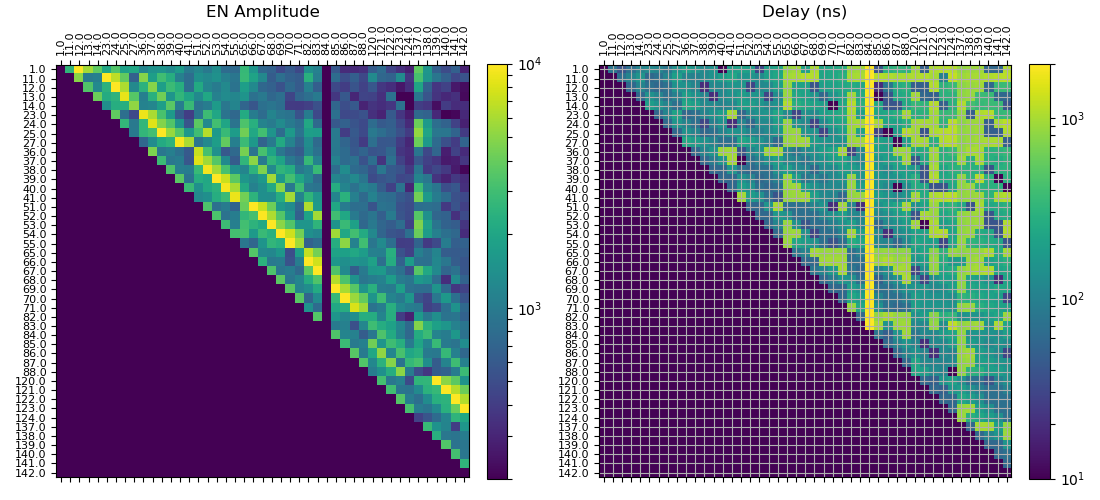

In [40]:
antennas = list(set(max_amp_xy[:,0]))
antennas.sort()

fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)
cax = ax.matshow(amp_matrix_xy,norm=SymLogNorm(vmin=200,vmax=10000,linthresh=.1))#cmap='tab20c')
fig.colorbar(cax,fraction=0.046, pad=0.04)
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('EN Amplitude',pad=20)
#plt.grid()

ax2 = fig.add_subplot(122)
cax2 = ax2.matshow(np.abs(delay_matrix_xy),norm=SymLogNorm(vmin=10,vmax=2000,linthresh=.1))#cmap='seismic')
fig.colorbar(cax2,fraction=0.046, pad=0.04)
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('Delay (ns)',pad=20)
plt.grid()

plt.tight_layout()
plt.show()

Now we do the same thing for the YX polarized data

In [41]:
#Initialize the array for the amplitudes of the yx data and the corresponding delay
max_amp_yx,delay_yx=make_max_arrays(uvy)

print delay_yx.shape
print max_amp_yx.shape

amp_matrix_yx,delay_matrix_yx=make_matrix_array(max_amp_yx,delay_yx)

print amp_matrix_yx.shape
print delay_matrix_yx.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Now we plot the matrices

<IPython.core.display.Javascript object>


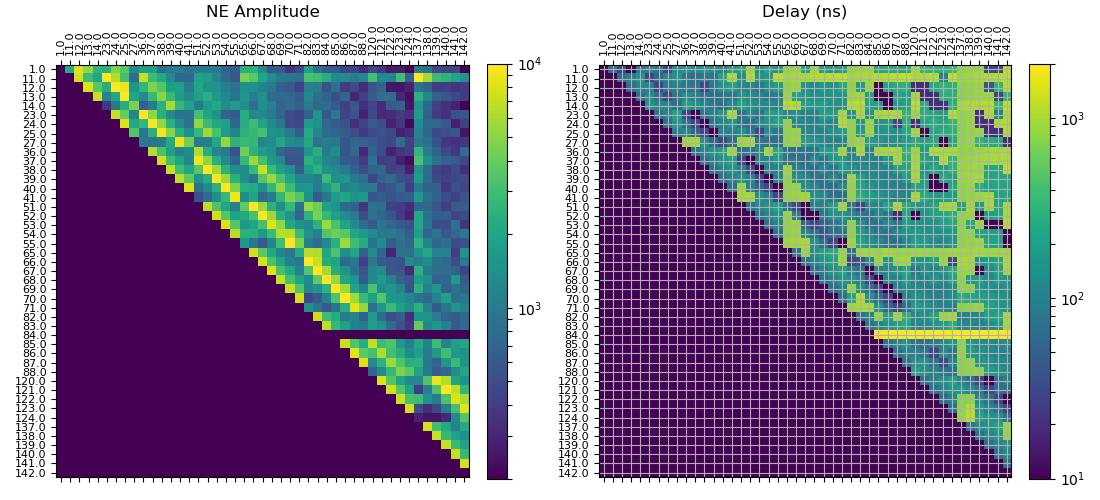

In [42]:
antennas2 = list(set(max_amp_yx[:,0]))
antennas2.sort()

fig = plt.figure(figsize=(11,5))

ax3 = fig.add_subplot(121)
cax3 = ax3.matshow(amp_matrix_yx,norm=SymLogNorm(vmin=200,vmax=10000,linthresh=.1))#cmap='tab20c')
fig.colorbar(cax3,fraction=0.046, pad=0.04)
plt.xticks(np.arange(45), antennas2, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas2, fontsize=8)
plt.title('NE Amplitude', pad=20)
#plt.grid()

ax4 = fig.add_subplot(122)
cax4 = ax4.matshow(np.abs(delay_matrix_yx),norm=SymLogNorm(vmin=10,vmax=2000,linthresh=.1))#cmap='seismic')
fig.colorbar(cax4,fraction=0.046, pad=0.04)
plt.xticks(np.arange(45), antennas2, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas2, fontsize=8)
plt.title('Delay (ns)',pad=20)

plt.grid()

plt.tight_layout()
plt.show()

We are still not sure how much of the delay spectrum is showing actual data, and how much is caused by bouncing between other antennas or bouncing in the cables. 

To try and look at how much is baseline or cable dependent, we make a contour map with levels for the desired lengths

In [43]:
"""
plt.figure(figsize=(6,12))

#Create variables for the axes
x = antennas2
y = antennas2
z = delay_matrix_yx

#Create a variable to convert meters to nanoseconds
f = 3*0.082
air = 0.3
#Create a list of the baseline levels
blin = [-40./air,-20./air,-17./air,-16./air,-15./air,-14./air,-13./air,
          0,
          13./air,14./air,15./air,16./air,17./air,20./air,40./air]

#Create a list of the cable levels
cable = [-310./f,-300./f,-290./f,-160./f,-150./f,-140./f,
        0,
        140./f,150./f,160./f,290./f,300./f,310./f]

#Create list of color values
colors = ['#0B5345','#0E6655','#117a65','#138d75',
         'w',
         '#2980b9','#2471a3','#1f618d','#1a5276','#154360']

X, Y = np.meshgrid(x,y)

plt.subplot(211)
plt.contour(x,y,z,blin,colors='black')
#plt.contourf(x,y,z, blin, origin='upper')#, colors=colors)#cmap='hsv')
plt.colorbar()
plt.title('EN Baseline Contours')

plt.subplot(212)
plt.contour(x,y,z,cable,colors='black')
#plt.contourf(x,y,z, cable, origin='upper')#, colors=colors)#cmap='hsv')
plt.colorbar()
plt.title('EN Cable Contour')

plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(6,12))\n\n#Create variables for the axes\nx = antennas2\ny = antennas2\nz = delay_matrix_yx\n\n#Create a variable to convert meters to nanoseconds\nf = 3*0.082\nair = 0.3\n#Create a list of the baseline levels\nblin = [-40./air,-20./air,-17./air,-16./air,-15./air,-14./air,-13./air,\n          0,\n          13./air,14./air,15./air,16./air,17./air,20./air,40./air]\n\n#Create a list of the cable levels\ncable = [-310./f,-300./f,-290./f,-160./f,-150./f,-140./f,\n        0,\n        140./f,150./f,160./f,290./f,300./f,310./f]\n\n#Create list of color values\ncolors = ['#0B5345','#0E6655','#117a65','#138d75',\n         'w',\n         '#2980b9','#2471a3','#1f618d','#1a5276','#154360']\n\nX, Y = np.meshgrid(x,y)\n\nplt.subplot(211)\nplt.contour(x,y,z,blin,colors='black')\n#plt.contourf(x,y,z, blin, origin='upper')#, colors=colors)#cmap='hsv')\nplt.colorbar()\nplt.title('EN Baseline Contours')\n\nplt.subplot(212)\nplt.contour(x,y,z,cable,colors='black')\n#plt.contourf(x,y,

In [44]:
vis = uvx.get_data(13,140)
print vis
print vis.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay = np.fft.fftshift(np.fft.fft(np.mean(vis,axis=0)))
print vis_avg_delay
print vis_avg_delay.shape

# 2) Find the frequency width of a channel in GHz
freq_width = np.diff(uvx.freq_array[0,:])[0]
print freq_width

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays = np.fft.fftshift(np.fft.fftfreq(uvx.Nfreqs,freq_width))*1e9
print delays
print delays.shape

print np.max(np.abs(vis_avg_delay))
print delays[np.argmax(np.abs(vis_avg_delay))]

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[17.118702 -21.81135j   -2.0676174-10.867376j   7.152172 -12.441624j  ...
 26.151031  +0.5118294j 10.943022  -9.871252j  19.32965   +1.7659903j]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
312.17453
-360.0


In [45]:
vis2 = uvy.get_data(13,140)
print vis2
print vis2.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay2 = np.fft.fftshift(np.fft.fft(np.mean(vis2,axis=0)))
print vis_avg_delay2
print vis_avg_delay2.shape

# 2) Find the frequency width of a channel in GHz
freq_width2 = np.diff(uvy.freq_array[0,:])[0]
print freq_width2

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays2 = np.fft.fftshift(np.fft.fftfreq(uvy.Nfreqs,freq_width2))*1e9
print delays2
print delays2.shape

print np.max(np.abs(vis_avg_delay2))
print delays2[np.argmax(np.abs(vis_avg_delay2))]

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[-24.94001  -16.964424j  -17.177807  -2.1135883j -11.275375 -10.090996j
 ...   5.8648415-23.73135j    -2.422554  -5.398224j
  -1.7999954-20.579777j ]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
590.6513
-940.0


<IPython.core.display.Javascript object>


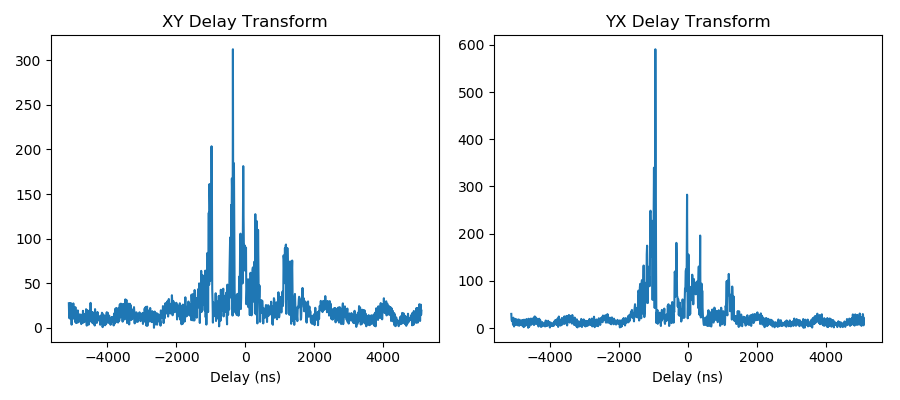

In [46]:
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.plot(delays,np.abs(vis_avg_delay))
plt.xlabel('Delay (ns)')
#plt.xlim(100,200) # zoom-in
#plt.ylim(0,600)
plt.title('XY Delay Transform');

plt.subplot(122)
plt.plot(delays2,np.abs(vis_avg_delay2))
plt.xlabel('Delay (ns)')
#plt.ylim(0,500)
#plt.xlim(-1000,1000) # zoom-in
plt.title('YX Delay Transform');

plt.tight_layout()

<IPython.core.display.Javascript object>


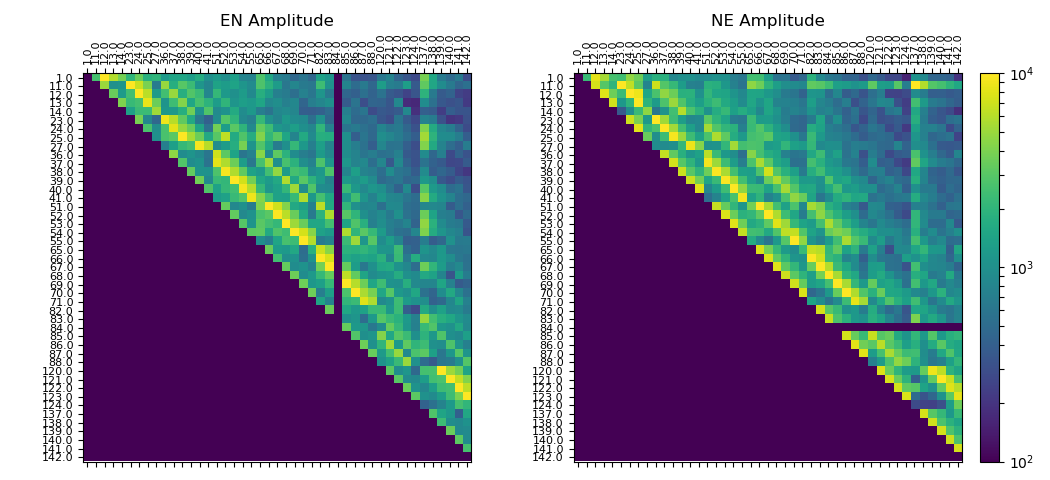

In [47]:
fig = plt.figure(figsize=(10.5,4.8))

ax_1 = fig.add_subplot(121)
cax_1 = ax_1.matshow(amp_matrix_xy,norm=SymLogNorm(vmin=100,vmax=10000,linthresh=.1))
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('EN Amplitude',pad=20)
#plt.grid()

ax_2 = fig.add_subplot(122)
cax_2 = ax_2.matshow(amp_matrix_yx,norm=SymLogNorm(vmin=100,vmax=10000,linthresh=.1))
plt.xticks(np.arange(45), antennas2, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas2, fontsize=8)
plt.title('NE Amplitude',pad=20)
#plt.grid()

plt.colorbar(cax_2,fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

We've been able to plot matrices of the maximum amplitude, but now we want to be able to visualize where the antennas actually are in relation to each other (for instance, could then see that the antennas next to each other are most strongly correlated). 

To begin, let's read in the antenna positions and plot the general graph of the array. 

We will want to have a user prompt for the position map so that the user can imput the antenna they want to focus on and see the relationships with the other antennas. 

In [48]:
#Read in the position and antenna numbers for all antennas
antpos, ants = uvx.get_ENU_antpos()

#This function checks to see if the entered antenna number matches with a known antenna number
#If it does, the number is printed and returned to the variable that called the function
#If it does not, an error message is printed and the user is prompted to enter a new number
#The funtion is then called again to check the new number entered
#This repeats until the user enters a valid antenna number
def check_antnum(antnum):
    if np.any(antnum==ants):
        print(antnum)
        return antnum
    else:
        print 'Number entered does not correspond to a known antenna.'
        new_ant = input("Which antenna would you like to look at? Enter here: ")
        new_ant = int(new_ant)
        new_ant = check_antnum(new_ant)
        return int(new_ant)

In [86]:
#Ask the user to input the desired antenna
focus_ant = input("Which antenna would you like to look at? Enter here: ")
#Take the input and represent as an integer
focus_ant = int(focus_ant)
#Run a check that the number is valid
focus_ant = check_antnum(focus_ant)

#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_xy, full_ant_delay_xy = make_max_arrays(uvx, keep_flags=True)
all_ants_amp_xy, all_ants_delay_xy, index, dindex = make_matrix_array(full_ant_amp_xy, full_ant_delay_xy, antnum=focus_ant, index=True)

#Create the arrays for the maximum values and the matrix for yx
full_ant_amp_yx, full_ant_delay_yx = make_max_arrays(uvy, keep_flags=True)
all_ants_amp_yx, all_ants_delay_yx, indexy, dindexy = make_matrix_array(full_ant_amp_yx, full_ant_delay_yx, antnum=focus_ant, index=True)

Which antenna would you like to look at? Enter here: 14
14


Now we can actually plot the antennas with both amplitude and delay fuctioning as the color scale

<IPython.core.display.Javascript object>


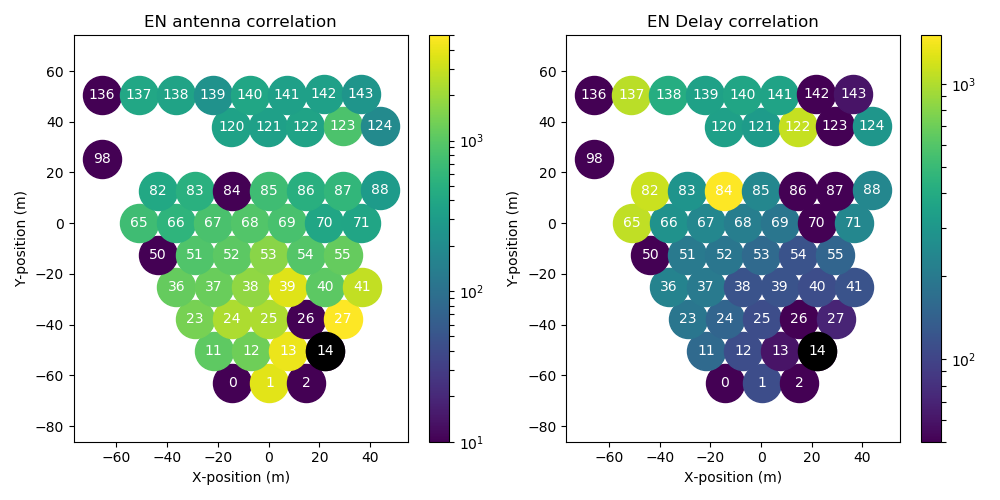

In [87]:
#Plot the array of antennas with color representing amplitude for xy
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')
for aa in range(52):
    #Get the amplitude value for the current antenna pair
    color = all_ants_amp_xy[index,aa]
    #Convert into integer
    color = int(color)
    #Plot the antennas with the corresponding colors
    xim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
    #Print the entered antenna in red
    if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.title('EN antenna correlation')
plt.axis('equal')
plt.colorbar(xim)


#Plot the array of antennas with color representing delay time
plt.subplot(122)
plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa in range(52):
    #Get the delay value for the current antenna pair
    dcolor = all_ants_delay_xy[dindex,aa]
    #Convert into integer
    dcolor = int(dcolor)
    dcolor = np.abs(dcolor)
    #Plot the antennas with the corresponding colors
    dxim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolor,norm=SymLogNorm(vmin=50,vmax=1500,linthresh=.1))
#Print the antenna numbers
for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
    #Print the entered antenna in red
    if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.title('EN Delay correlation')
plt.axis('equal')
plt.colorbar(dxim)

plt.tight_layout()

<IPython.core.display.Javascript object>


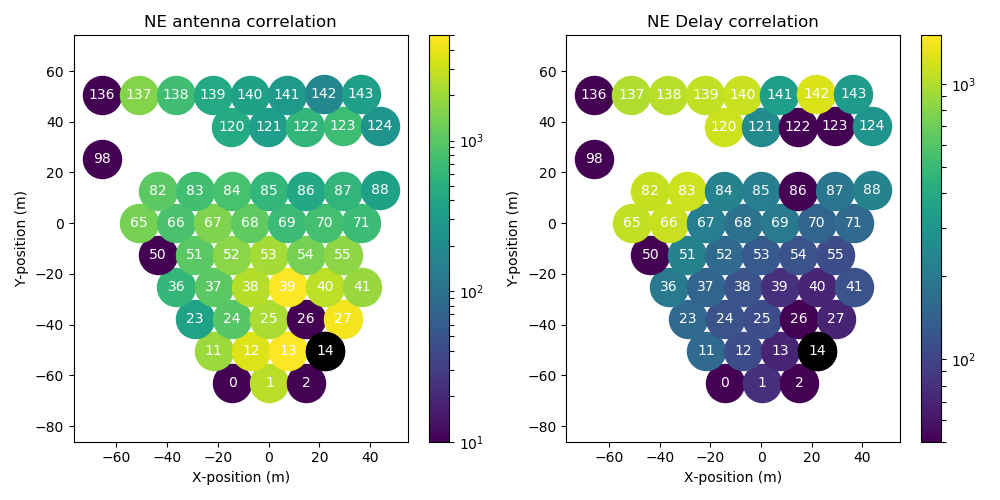

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(121)
#Plot the array of antennas with color representing amplitude for yx
plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa in range(52):
    #Get the amplitude value for the current antenna pair
    colory = all_ants_amp_yx[indexy,aa]
    #Convert into integer
    colory = int(colory)
    #Plot the antennas with the corresponding colors
    im=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=colory,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
    #Print the entered antenna in red
    if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.title('NE antenna correlation')
plt.axis('equal')
plt.colorbar(im)


#Plot the array of antennas with color representing delay time
plt.subplot(122)
plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa in range(52):
    #Get the delay value for the current antenna pair
    dcolory = all_ants_delay_yx[dindexy,aa]
    #Convert into integer
    dcolory = int(dcolory)
    dcolory = np.abs(dcolory)
    #Plot the antennas with the corresponding colors
    dim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolory,norm=SymLogNorm(vmin=50,vmax=1500,linthresh=.1))
#Print the antenna numbers
for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
    #Print the entered antenna in red
    if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.title('NE Delay correlation')
plt.axis('equal')
plt.colorbar(dim)

plt.tight_layout()

Now let's look at how far away the delay times correspond to. This means that instead of plotting the antenna amplitudes at the given antenna location, we need to plot them at the distance given by the delay. 

The delay is given in ns and we need it in m: distance = all_ants_delay[index,aa] * 3e8
<p>OR
<p>distance = all_ants_delay[index,aa] * 3e8 * 0.8

We also need to know the physical distance separating the antennas. This can be done by indexing the antenna positions array to get the x and y coordinates of the given antenna pair. The difference between the two x coordinates acts as the horizontal distance between the two antennas, and the difference between the two y coordinates acts as the vertical distance. 
<p>These two numbers act as the sides of a triangle and the hypotenus is the total physical distance between the antennas in meters. This number is then placed in the corresponding array element. 

In [107]:
#Variable for the speed of light, with power adjusted for desired units
c = 0.299792
#Variable for speed of light in a cable correction factor
f = 0.8

#Create an array which holds the delay times in meters
delay_distance = all_ants_delay_yx * c
delay_distance_xy = all_ants_delay_xy * c

#Create an array which holds the delay times in meters, with the cable correction factor
dd_cable_yx = all_ants_delay_yx * c * f
dd_cable_xy = all_ants_delay_xy * c * f

#Create an array which holds the physical distance between each antenna in meters 
blin_length = np.zeros((52,1))
#Step through each antenna pair with the entered antenna
for aa,ant in enumerate(ants):
    #Find the horizontal distance between the two
    x = antpos[indexy,0] - antpos[aa,0]
    #Find the vertical distance between the two
    y = antpos[indexy,1] - antpos[aa,1]
    #Find the hypotenus of the triangle
    diag = np.sqrt(x**2 + y**2)
    #Place this value into the array
    blin_length[aa] = diag

#print blin_length

<IPython.core.display.Javascript object>


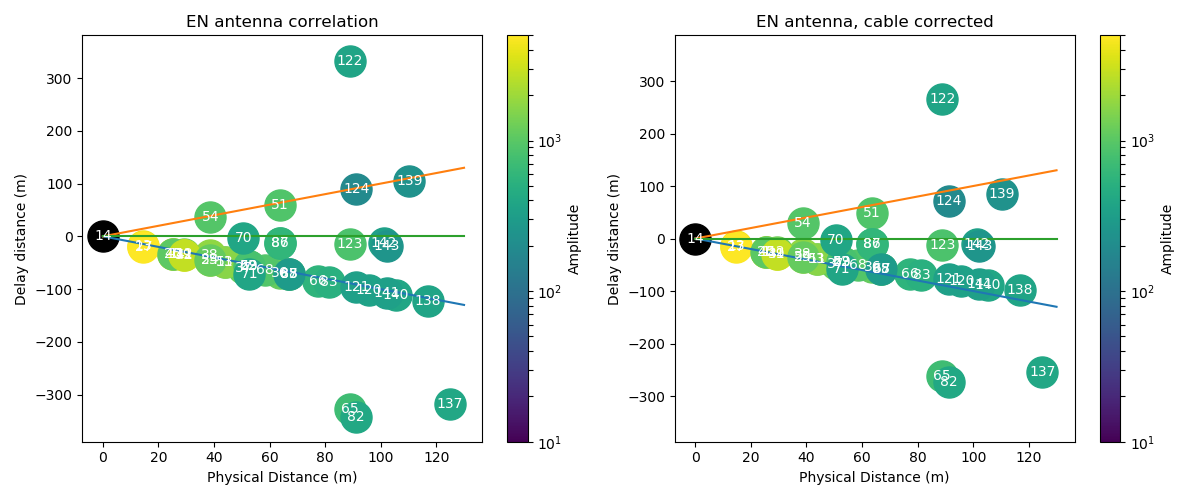

In [112]:
plt.figure(figsize=(12,5))
plt.subplot(121)
#Plot the array of antennas with color representing amplitude for yx
#plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa,ant in enumerate(ants):
    #Get the amplitude value for the current antenna pair
    color = all_ants_amp_xy[index,aa]
    #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
    if ant==focus_ant:
        plt.scatter(0,0,marker='.',color='black',s=2000)
    #Skip flagged antennas
    #I also flag antenna 84 because it throws off the scale of the graph because one dipole is dead
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Now we plot the remaining antennas with the color representing the amplitude
    #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
    #The y coordinate corresponds to the delay distance found by the antennas
    else: imx=plt.scatter(blin_length[aa,0],delay_distance_xy[index,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    #If the current antenna is the focus antenna, manually print number at 0,0
    if ant==focus_ant: 
        plt.text(0,0,ants[aa],color='w',va='center',ha='center')
    #Skip flagged antennas
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Print the remaining antenna numbers at the correct coordinates
    else: plt.text(blin_length[aa,0],delay_distance_xy[index,aa],ants[aa],color='w',va='center',ha='center')
#Plot lines on the diagonal and the zero
x = np.linspace(0,130)
line = np.linspace(0,0)
plt.plot(x,-x)
plt.plot(x,x)
plt.plot(x,line)
#Print labels
plt.xlabel('Physical Distance (m)')
plt.ylabel('Delay distance (m)')
plt.title('EN antenna correlation')
plt.colorbar(imx, label='Amplitude')

plt.subplot(122)
#Plot the array of antennas with color representing amplitude for yx
#plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa,ant in enumerate(ants):
    #Get the amplitude value for the current antenna pair
    color = all_ants_amp_xy[index,aa]
    #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
    if ant==focus_ant:
        plt.scatter(0,0,marker='.',color='black',s=2000)
    #Skip flagged antennas
    #I also flag antenna 84 because it throws off the scale of the graph because one dipole is dead
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Now we plot the remaining antennas with the color representing the amplitude
    #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
    #The y coordinate corresponds to the delay distance found by the antennas
    else: cimx=plt.scatter(blin_length[aa,0],dd_cable_xy[index,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    #If the current antenna is the focus antenna, manually print number at 0,0
    if ant==focus_ant: 
        plt.text(0,0,ants[aa],color='w',va='center',ha='center')
    #Skip flagged antennas
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Print the remaining antenna numbers at the correct coordinates
    else: plt.text(blin_length[aa,0],dd_cable_xy[index,aa],ants[aa],color='w',va='center',ha='center')
#Plot lines on the diagonal and the zero
plt.plot(x,-x)
plt.plot(x,x)
plt.plot(x,line)
#Print labels
plt.xlabel('Physical Distance (m)')
plt.ylabel('Delay distance (m)')
plt.title('EN antenna, cable corrected')
plt.colorbar(cimx, label='Amplitude')
#Zoom out so the two graphs have the same window
plt.ylim(-387,387)

plt.tight_layout()

<IPython.core.display.Javascript object>


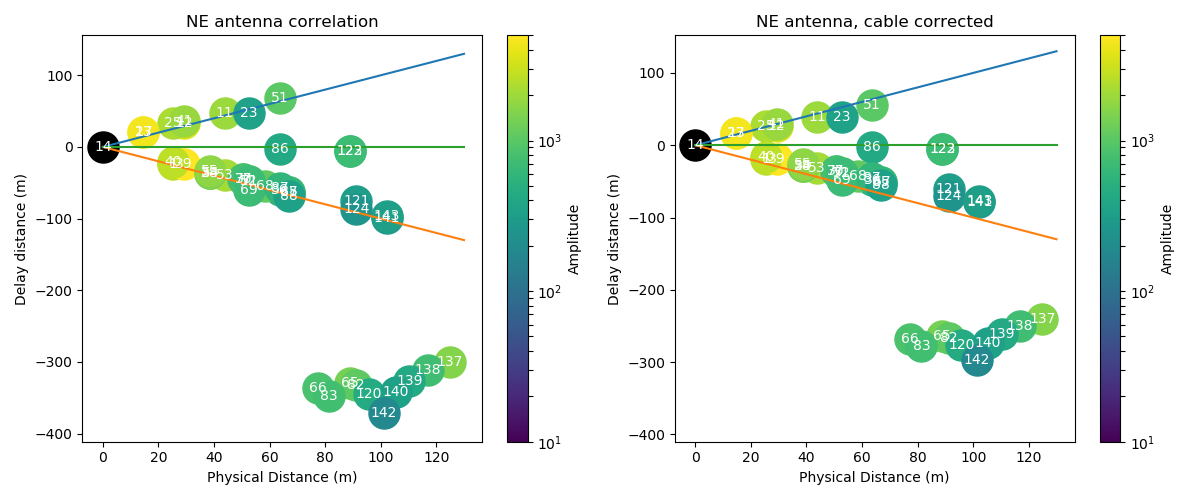

In [120]:
plt.figure(figsize=(12,5))
plt.subplot(121)
#Plot the array of antennas with color representing amplitude for yx
#plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa,ant in enumerate(ants):
    #Get the amplitude value for the current antenna pair
    colory = all_ants_amp_yx[indexy,aa]
    #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
    if ant==focus_ant:
        plt.scatter(0,0,marker='.',color='black',s=2000)
    #Skip flagged antennas
    #I also flag antenna 84 because it throws off the scale of the graph because one dipole is dead
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Now we plot the remaining antennas with the color representing the amplitude
    #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
    #The y coordinate corresponds to the delay distance found by the antennas
    else: imx=plt.scatter(blin_length[aa,0],delay_distance[indexy,aa],marker='.',s=2000,c=colory,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    #If the current antenna is the focus antenna, manually print number at 0,0
    if ant==focus_ant: 
        plt.text(0,0,ants[aa],color='w',va='center',ha='center')
    #Skip flagged antennas
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Print the remaining antenna numbers at the correct coordinates
    else: plt.text(blin_length[aa,0],delay_distance[indexy,aa],ants[aa],color='w',va='center',ha='center')
#Plot lines on the diagonal and the zero
plt.plot(x,x)
plt.plot(x,-x)
plt.plot(x,line)
#Print labels
plt.xlabel('Physical Distance (m)')
plt.ylabel('Delay distance (m)')
plt.title('NE antenna correlation')
plt.colorbar(im, label='Amplitude')

plt.subplot(122)
#Plot the array of antennas with color representing amplitude for yx
#plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
for aa,ant in enumerate(ants):
    #Get the amplitude value for the current antenna pair
    colory = all_ants_amp_yx[indexy,aa]
    #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
    if ant==focus_ant:
        plt.scatter(0,0,marker='.',color='black',s=2000)
    #Skip flagged antennas
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Now we plot the remaining antennas with the color representing the amplitude
    #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
    #The y coordinate corresponds to the delay distance found by the antennas
    else: cim=plt.scatter(blin_length[aa,0],dd_cable_yx[indexy,aa],marker='.',s=2000,c=colory,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
#Print the antetnna numbers
for aa,ant in enumerate(ants):
    #If the current antenna is the focus antenna, manually print number at 0,0
    if ant==focus_ant: 
        plt.text(0,0,ants[aa],color='w',va='center',ha='center')
    #Skip flagged antennas
    elif np.any(ant==flagged_antennas) or ant==84: continue
    #Print the remaining antenna numbers at the correct coordinates
    else: plt.text(blin_length[aa,0],dd_cable_yx[indexy,aa],ants[aa],color='w',va='center',ha='center')
#Plot lines on the diagonals and the zero
plt.plot(x,x)
plt.plot(x,-x)
plt.plot(x,line)
#Print labels
plt.xlabel('Physical Distance (m)')
plt.ylabel('Delay distance (m)')
plt.title('NE antenna, cable corrected')
plt.colorbar(cim, label='Amplitude')
#Zoom out so the two graphs have the same window
plt.ylim(-410,152)

plt.tight_layout()